<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Fine-Tuning Transformers with PyTorch and Hugging Face**

Estimated time needed: **45** minutes


# Introduction

This project aims to introduce you to the process of loading and fine-tuning pretrained large language models (LLMs) 

You will learn how to implement the training loop of a model using pytorch to tune a model on task-specific data, as well as fine-tuning a model on task-specific data using the SFTTrainer module from Hugging Face. Finally, you will learn how to evaluate the performance of the fine-tuned models.

By the end of this project, you will have a solid understanding of how to leverage pretrained LLMs and fine-tune them for your specific use cases, empowering you to create powerful and customized natural language processing solutions.


# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li><a href="#Supervised-Fine-tuning-with-PyTorch)">Supervised Fine-tuning with Pytorch</a>
        <ol>
            <li><a href="#Dataset-preparations">Dataset preparations</a></li>
            <li><a href="#Train-the-model">Train the model</a></li>
            <li><a href="#Evaluate">Evaluate</a></li>
            <li><a href="#Loading-the-saved-model">Loading the saved model</a></li>
        </ol>
    </li>
    <li><a href="#Exercise:-Training-a-conversational-model-using-SFTTrainer">Exercise: Training a conversational model using SFTTrainer</a></li>
</ol>


---


# Objectives

After completing this lab, you will be able to:

 - Load pretrained LLMs from Hugging Face and make inferences
 - Fine-tune a model on task-specific data using the SFTTrainer module from Hugging Face
 - Load a SFTTrainer pretrained model and make comparisons
 - Evaluate the model


---


# Setup


### Installing required libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!pip` in the code cell below.


In [20]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 torch=2.1.0+cu118
# - Update a specific package
# !pip install pmdarima -U
# - Update a package to specific version
# !pip install --upgrade pmdarima==2.0.2
# Note: If your environment doesn't support "!pip install", use "!mamba install"

In [21]:
%%time
%pip install -U \
  torch==2.3.0+cpu \
  transformers==4.42.1 \
  datasets \
  trl==0.9.4 \
  torchmetrics \
  matplotlib==3.9.0 \
  lightning-utilities \
  --extra-index-url https://download.pytorch.org/whl/cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
CPU times: user 59.5 ms, sys: 167 ms, total: 227 ms
Wall time: 2.62 s


### Importing required libraries

_It is recommended that you import all required libraries in one place (here):_
* Note: If you get an error after running the cell below, try restarting the Kernel, as some packages need a restart to be effective.


In [2]:
%pip install -U rich

Note: you may need to restart the kernel to use updated packages.


In [1]:
# -----------------------------
# Suppress warnings
# -----------------------------
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# Core Python
# -----------------------------
import math
import time

# -----------------------------
# PyTorch
# -----------------------------
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

# -----------------------------
# Metrics
# -----------------------------
from torchmetrics import Accuracy

# -----------------------------
# Hugging Face Datasets
# -----------------------------
from datasets import load_dataset

# -----------------------------
# Transformers
# -----------------------------
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    BertConfig,
    BertForMaskedLM,
    BertTokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    pipeline,
)

# -----------------------------
# TRL (Supervised Fine-Tuning)
# -----------------------------
from trl import (
    SFTConfig,
    SFTTrainer,
    DataCollatorForCompletionOnlyLM,
)

# -----------------------------
# Utilities
# -----------------------------
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Supervised Fine-tuning with Pytorch

Fine-tuning Transformers, specifically BERT (Bidirectional Encoder Representations from Transformers), refers to the process of training a pretrained BERT model on a specific downstream task. BERT is an encoder-only language model that has been pretrained on a large corpus of text to learn contextual representations of words.

Fine-tuning BERT involves taking the pretrained model and further training it on a task-specific dataset, such as sentiment analysis or question answering. During fine-tuning, the parameters of the pretrained BERT model are updated and adapted to the specifics of the target task.

This process is important because it allows you to leverage the knowledge and language understanding captured by BERT and apply it to different tasks. By fine-tuning BERT, you can benefit from its contextual understanding of language and transfer that knowledge to specific domain-specific or task-specific problems. Fine-tuning enables BERT to learn from a smaller labeled dataset and generalize well to unseen examples, making it a powerful tool for various natural language processing tasks. It helps to bridge the gap between pretraining on a large corpus and the specific requirements of downstream applications, ultimately improving the performance and effectiveness of models in various real-world scenarios.


## Dataset preparations

The Yelp review dataset is a widely used dataset in natural language processing (NLP) and sentiment analysis research. It consists of user reviews and accompanying metadata from the Yelp platform, which is a popular online platform for reviewing and rating local businesses such as restaurants, hotels, and shops.

The dataset includes 6,990,280 reviews written by Yelp users, covering a wide range of businesses and locations. Each review typically contains the text of the review itself alongwith the star rating given by the user (ranging from 1 to 5).

Our aim in this lab, is to fine-tune a pretrained BERT model to predict the ratings from reviews.


Let's start by loading the yelp_review data:


In [2]:
dataset = load_dataset("yelp_review_full")

dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

Let's check a sample record of the dataset:


In [3]:
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

the label is the key of the class label


In [4]:
dataset["train"][100]["label"]

0

there is also the text


In [5]:
dataset["train"][100]['text']

'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. I\'ve worked at more t

You can select a portion of data to decrease the training time:


In [6]:
dataset["train"] = dataset["train"].select([i for i in range(100)])
dataset["test"] = dataset["test"].select([i for i in range(20)])

There are two data fields:
- label: the label for the review
- text: a string containing the body of the user review


### Tokenizing data

The next step is to load a BERT tokenizer to tokenize, pad and truncate reviews to handle variable-length sequences:


In [7]:
# Instantiate a tokenizer using the BERT base cased model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Define a function to tokenize examples
def tokenize_function(examples):
    # Tokenize the text using the tokenizer
    # Apply padding to ensure all sequences have the same length
    # Apply truncation to limit the maximum sequence length
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Apply the tokenize function to the dataset in batches
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

The keys in each element of tokenized_datasets are 'label', 'text', 'input_ids', 'token_type_ids', and 'attention_mask'.


In [8]:
tokenized_datasets['train'][0].keys()

dict_keys(['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'])

To apply the preprocessing function over the entire dataset, let's use the map method. You can speed up the map function by setting batched=True to process multiple elements of the dataset at once:


Since the model is built on the PyTorch framework, it is crucial to prepare the dataset in a format that PyTorch can readily process. Follow these steps to ensure compatibility:


In [9]:
# Remove the text column because the model does not accept raw text as an input
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the label column to labels because the model expects the argument to be named labels
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format of the dataset to return PyTorch tensors instead of lists
tokenized_datasets.set_format("torch")

the result is a set of tensors with the keys as:  'labels', 'input_ids', 'token_type_ids', 'attention_mask'


In [10]:
tokenized_datasets['train'][0].keys()

dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])

### DataLoader


Next, create a DataLoader for train and test datasets so you can iterate over batches of data:


In [11]:
# Create a training data loader
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=2)

# Create an evaluation data loader
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=2)

## Train the model


You’re ready to start training your model, now!
In this section, you will learn to create the training loop from scratch without the help of the Hugging Face trainer class.
In the MLM task, you utilized the Hugging Face trainer module. Now, you will develop the trainer yourself.


### Load a pretrained model


Here, you'll load a pretrained classification model with 5 classes:


In [12]:
# Instantiate a sequence classification model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Optimizer and learning rate schedule

Let's create an optimizer and learning rate scheduler to fine-tune the model. You can use the AdamW optimizer from PyTorch:


In [13]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-4)

# Set the number of epochs
num_epochs = 1

# Calculate the total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Define the learning rate scheduler
lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda current_step: (1 - current_step / num_training_steps))

 Check if CUDA is available and, then set the device accordingly.


In [14]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move the model to the appropriate device
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Training loop

You are ready to fine-tune the model. To keep track of training progress, let's use the "tqdm" library to add a progress bar over the number of training steps.
The train_model function trains a model using a set of training data provided through a dataloader. It begins by setting up a progress bar to help monitor the training progress visually. The model is switched to training mode, which is necessary for certain model behaviors like dropout to work correctly during training. The function processes the data in batches for each epoch, which involves several steps for each batch: transferring the data to the correct device (like a GPU), running the data through the model to get outputs and calculate loss, updating the model's parameters using the calculated gradients, adjusting the learning rate, and clearing the old gradients. These steps are repeated for each batch of data, and the progress bar is updated accordingly to reflect the progress. Once all epochs are completed, the trained model is saved to be used later.









In [15]:
def train_model(model,tr_dataloader):

    # Create a progress bar to track the training progress
    progress_bar = tqdm(range(num_training_steps))

    # Set the model in training mode
    model.train()
    tr_losses=[]
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0 
        # Iterate over the training data batches
        for batch in tr_dataloader:
            # Move the batch to the appropriate device
            batch = {k: v.to(device) for k, v in batch.items()}
            # Forward pass through the model
            outputs = model(**batch)
            # Compute the loss
            loss = outputs.loss
            # Backward pass (compute gradients)
            loss.backward()
            
            total_loss += loss.item()
            # Update the model parameters
            optimizer.step()
            # Update the learning rate scheduler
            lr_scheduler.step()
            # Clear the gradients
            optimizer.zero_grad()
            # Update the progress bar
            progress_bar.update(1)
        tr_losses.append(total_loss/len(tr_dataloader))
    #plot loss
    plt.plot(tr_losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()  


## Evaluate
The evaluate_model function works similarly to the train_model function but is used for evaluating the model's performance instead of training it. It uses a dataloader to process data in batches, setting the model to evaluation mode to ensure accuracy in measurements and disabling gradient calculations since it's not training. The function calculates predictions for each batch, updates an accuracy metric, and finally, prints the overall accuracy after processing all batches.








In [16]:

def evaluate_model(model, evl_dataloader):
    # Create an instance of the Accuracy metric for multiclass classification with 5 classes
    metric = Accuracy(task="multiclass", num_classes=5).to(device)

    # Set the model in evaluation mode
    model.eval()

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Iterate over the evaluation data batches
        for batch in evl_dataloader:
            # Move the batch to the appropriate device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass through the model
            outputs = model(**batch)

            # Get the predicted class labels
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Accumulate the predictions and labels for the metric
            metric(predictions, batch["labels"])

    # Compute the accuracy
    accuracy = metric.compute()

    # Print the accuracy
    print("Accuracy:", accuracy.item())



You can now train the model. This process will take a long time, and it is highly recommended that you do this only if you have the required resources. Please uncomment the following code to train the model.


In [17]:
from tqdm.auto import tqdm

  0%|          | 0/50 [00:00<?, ?it/s]

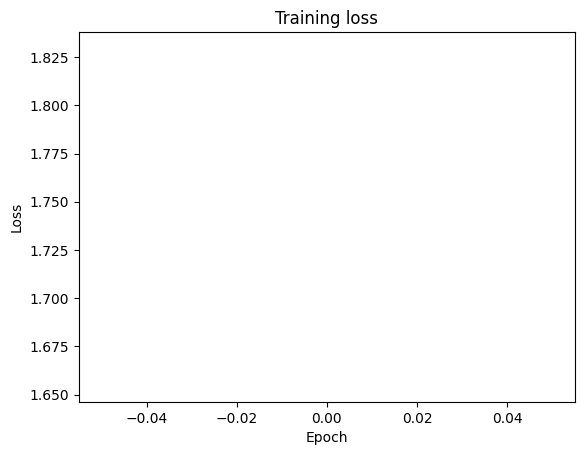

In [18]:
train_model(model=model,tr_dataloader=train_dataloader)

torch.save(model, 'my_model.pt')

![loss_gpt.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HausLW2F_w30s1UK0zj7mQ/training-loss-BERT-Classification.png)


You are now ready to learn how to tune a more complex model that can generate conversations between a human and an assistant.


## Loading the saved model
If you want to skip training and load the model that you trained for 10 epochs, go ahead and uncomment the following cell:


In [19]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wFhKpkBMSgjmZKRSyayvsQ/bert-classification-model.pt'
model.load_state_dict(torch.load('bert-classification-model.pt',map_location=torch.device('cpu')))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2026-01-18 07:47:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wFhKpkBMSgjmZKRSyayvsQ/bert-classification-model.pt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 433341834 (413M) [binary/octet-stream]
Saving to: ‘bert-classification-model.pt’

bert-classification 100%[===================>] 413.27M  70.2MB/s    in 5.7s    

2026-01-18 07:47:30 (72.3 MB/s) - ‘bert-classification-model.pt’ saved [433341834/433341834]



<All keys matched successfully>

You can now evaluate the model. Please note that this process will take a while.


In [20]:
evaluate_model(model, eval_dataloader)

Accuracy: 0.15000000596046448


You are now ready to learn to tune a more complex model that can generate conversations between a human and an assistant using SFTtrainer.


# Exercise: Training a conversational model using SFTTrainer

The SFTTrainer from the trl (Transformers Reinforcement Learning) library is a tool used for supervised fine-tuning of language models. It helps refine pre-trained models using specific datasets to enhance their performance on targeted tasks.


## Objective
Explore how fine-tuning a decoder transformer using a specific dataset affects the quality of the generated responses in a question-answering task.


Step 1- Load the train split of "timdettmers/openassistant-guanaco" dataset from Hugging Face:


In [21]:
dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")
dataset[0]

README.md:   0%|          | 0.00/395 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


openassistant_best_replies_train.jsonl:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

openassistant_best_replies_eval.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

{'text': '### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

Step 2- Load the pretrained causal model "facebook/opt-350m" along with its tokenizer from Hugging Face:


In [ ]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

Step 3- Create instruction and response templates based on the train dataset format:


In [ ]:
instruction_template = "### Human:"
response_template = "### Assistant:"

Step 4- Create a collator to curate data in the appropriate shape for training using **"DataCollatorForCompletionOnlyLM"**:


In [ ]:
collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template, response_template=response_template, tokenizer=tokenizer, mlm=False)

Step 5- Create an SFTTrainer object and pass the model as well as the dataset and collator: 


In [ ]:
training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=1,
    #learning_rate=2e-5,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    #gradient_accumulation_steps=4,  # Accumulate gradients
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    args=training_args,
    train_dataset=dataset,
    dataset_text_field="text",
    data_collator=collator,
)

Step 6- Prompt the pretrained model with a specific question: 


In [ ]:
pipe = pipeline("text-generation", model=model,tokenizer=tokenizer,max_new_tokens=70)
print(pipe('''Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.''')[0]["generated_text"])

Looks like the model is barely aware of what "monopsony" is in the context of economics.


Step 6A (Optional)- Train the model:


In [ ]:
trainer.train()

If you do not have enough resources to run the training, load the tuned model we provide here: "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Assistant_model.pt":



Step 6B- Load the tuned model: 


In [ ]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Assistant_model.pt'
model.load_state_dict(torch.load('Assistant_model.pt',map_location=torch.device('cpu')))

Step 7- Check how the tuned model performs in answering the same specialized question:


In [ ]:
pipe = pipeline("text-generation", model=model,tokenizer=tokenizer,max_new_tokens=70)
print(pipe('''Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.''')[0]["generated_text"])